In [2]:
import numpy as np
import pandas as pd

# Load flux sequences and IDs
flux_sequences = np.load("flux_sequences.npy")
flux_kepler_ids = np.load("flux_kepler_ids.npy")

# Load multimodal merged dataset
merged_df = pd.read_csv("final_multimodal_dataset.csv")

# Match sequences to multimodal dataset by Kepler_ID
id_to_seq = {k: seq for k, seq in zip(flux_kepler_ids, flux_sequences)}
matched_seqs = []
matched_tabular = []
matched_labels = []

tabular_features = ['koi_steff', 'koi_slogg', 'koi_srad', 'koi_prad', 'koi_score', 'koi_period']

for _, row in merged_df.iterrows():
    kepler_id = row['Kepler_ID']
    if kepler_id in id_to_seq:
        matched_seqs.append(id_to_seq[kepler_id])
        matched_tabular.append(row[tabular_features].values)
        matched_labels.append(row['label'])

X_seq = np.array(matched_seqs)
X_tab = np.array(matched_tabular)
y = np.array(matched_labels)

print(f"✅ Matched {len(X_seq)} flux sequences with tabular data.")


✅ Matched 1411 flux sequences with tabular data.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Scale tabular inputs
scaler_tab = StandardScaler()
X_tab_scaled = scaler_tab.fit_transform(X_tab)

# Train-test split
X_seq_train, X_seq_test, X_tab_train, X_tab_test, y_train, y_test = train_test_split(
    X_seq, X_tab_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape (sequence):", X_seq_train.shape)
print("Train shape (tabular):", X_tab_train.shape)


Train shape (sequence): (1128, 512)
Train shape (tabular): (1128, 6)


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.models import Model

# === Transformer Encoder Block ===
def transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=128, dropout=0.2):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# Inputs
seq_input = Input(shape=(X_seq_train.shape[1], 1), name="sequence_input")
x_seq = transformer_encoder(seq_input)
x_seq = GlobalAveragePooling1D()(x_seq)

tab_input = Input(shape=(X_tab_train.shape[1],), name="tabular_input")
x_tab = Dense(64, activation='relu')(tab_input)
x_tab = Dropout(0.3)(x_tab)
x_tab = Dense(32, activation='relu')(x_tab)

# Fusion
combined = Concatenate()([x_seq, x_tab])
x = Dense(64, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[seq_input, tab_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence_input (InputLayer  [(None, 512, 1)]             0         []                            
 )                                                                                                
                                                                                                  
 layer_normalization (Layer  (None, 512, 1)               2         ['sequence_input[0][0]']      
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 512, 1)               897       ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0

Epoch 1/30


29/29 [==============================] - 12s 323ms/step - loss: 0.5826 - accuracy: 0.8381 - val_loss: 0.4256 - val_accuracy: 0.9735
Epoch 2/30
29/29 [==============================] - 9s 309ms/step - loss: 0.2571 - accuracy: 0.9778 - val_loss: 0.1251 - val_accuracy: 0.9867
Epoch 3/30
29/29 [==============================] - 10s 360ms/step - loss: 0.0822 - accuracy: 0.9800 - val_loss: 0.0857 - val_accuracy: 0.9912
Epoch 4/30
29/29 [==============================] - 11s 393ms/step - loss: 0.0758 - accuracy: 0.9823 - val_loss: 0.0847 - val_accuracy: 0.9912
Epoch 5/30
29/29 [==============================] - 11s 373ms/step - loss: 0.0579 - accuracy: 0.9867 - val_loss: 0.0834 - val_accuracy: 0.9823
Epoch 6/30
29/29 [==============================] - 11s 382ms/step - loss: 0.0549 - accuracy: 0.9856 - val_loss: 0.0872 - val_accuracy: 0.9823
Epoch 7/30
29/29 [==============================] - 11s 374ms/step - loss: 0.0558 - accuracy: 0.9878 - val_loss: 0.0875 - val_accuracy: 0.986

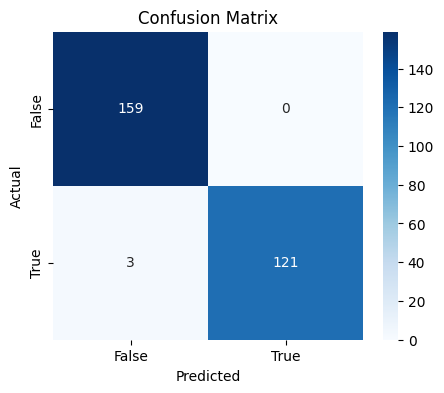

In [5]:
# Reshape sequence input for Transformer
X_seq_train_reshaped = X_seq_train[..., np.newaxis]
X_seq_test_reshaped = X_seq_test[..., np.newaxis]

# Train
history = model.fit(
    [X_seq_train_reshaped, X_tab_train], y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

# Evaluate
loss, accuracy = model.evaluate([X_seq_test_reshaped, X_tab_test], y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = (model.predict([X_seq_test_reshaped, X_tab_test]) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


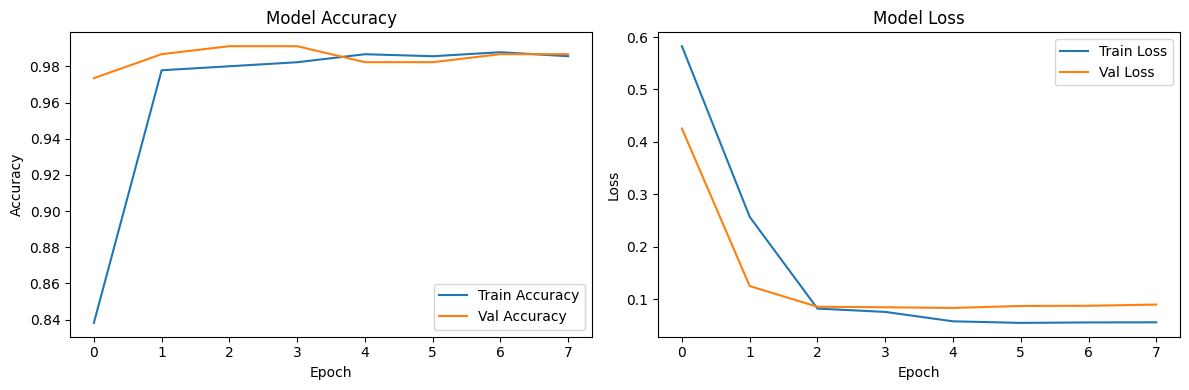

In [6]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
